In [1]:
%load_ext hamilton.plugins.jupyter_magic

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


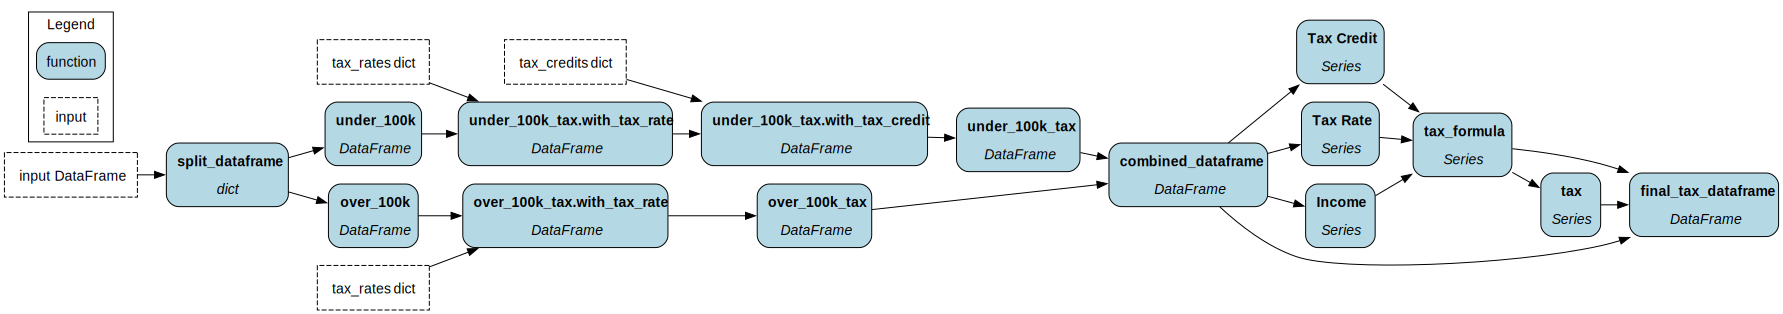

In [2]:
%%cell_to_module my_functions --display

from typing import Dict

import numpy as np
import pandas
import pandas as pd
from pandas import DataFrame, Series

from hamilton.function_modifiers import extract_columns, extract_fields, inject, pipe, source, step

# ----------------------------------------------------------------------------------------------------------------------
# Tax calculation private functions
# ----------------------------------------------------------------------------------------------------------------------


def _tax_rate(df: DataFrame, tax_rates: Dict[str, float]) -> DataFrame:
    """
    Add a series 'Tax Rate' to the DataFrame based on the tax_rates rules.
    :param df: The DataFrame
    :param tax_rates: Tax rates rules
    :return: the DataFrame with the 'Tax Rate' Series
    """
    output = DataFrame()
    for tax_rate_formula, tax_rate in tax_rates.items():
        selected = df.query(tax_rate_formula)
        if selected.empty:
            continue
        tmp = DataFrame({"Tax Rate": tax_rate}, index=selected.index)
        output = pd.concat([output, tmp], axis=0)
    df = pd.concat([df, output], axis=1)
    return df


def _tax_credit(df: DataFrame, tax_credits: Dict[str, float]) -> DataFrame:
    """
    Add a series 'Tax Credit' to the DataFrame based on the tax_credits rules.
    :param df: The DataFrame
    :param tax_credits: Tax credits rules
    :return: the DataFrame with the 'Tax Credit' Series
    """
    output = DataFrame()
    for tax_credit_formula, tax_credit in tax_credits.items():
        selected = df.query(tax_credit_formula)
        if selected.empty:
            continue
        tmp = DataFrame({"Tax Credit": tax_credit}, index=selected.index)
        output = pd.concat([output, tmp], axis=0)
    df = pd.concat([df, output], axis=1)
    return df


# ----------------------------------------------------------------------------------------------------------------------
# DataFlow: The functions defined below are displayed in the order of execution
# ----------------------------------------------------------------------------------------------------------------------


@extract_fields({"under_100k": DataFrame, "over_100k": DataFrame})
# Step 1: DataFrame is split in 2 DataFrames
def split_dataframe(input: DataFrame) -> Dict[str, DataFrame]:
    """
    That function takes the DataFrame in input and split it in 2 DataFrames:
      - under_100k: Rows where 'Income' is under 100k
      - over_100k: Rows where 'Income' is over 100k

    :param input: the DataFrame to process
    :return: a Dict with the DataFrames and the Tax Rates & Credit rules
    """
    return {
        "under_100k": input.query("Income < 100000"),
        "over_100k": input.query("Income >= 100000"),
    }


@pipe(
    step(_tax_rate, tax_rates=source("tax_rates")),  # apply the _tax_rate step
    step(_tax_credit, tax_credits=source("tax_credits")),  # apply the _tax_credit step
)
# Step 2: DataFrame for Income under 100k applies a tax calculation pipeline
def under_100k_tax(under_100k: DataFrame) -> DataFrame:
    """
    Tax calculation pipeline for 'Income' under 100k.
    :param under_100k: The DataFrame  where 'Income' is under 100k
    :return: the DataFrame with the 'Tax' Series
    """
    return under_100k


@pipe(
    step(_tax_rate, tax_rates=source("tax_rates")),  # apply the _tax_rate step
)
# Step 2: DataFrame for Income over 100k applies a tax calculation pipeline
def over_100k_tax(over_100k: DataFrame) -> DataFrame:
    """
    Tax calculation pipeline for 'Income' over 100k.
    :param over_100k: The DataFrame where 'Income' is over 100k
    :return: the DataFrame with the 'Tax' Series
    """
    return over_100k


@extract_columns("Income", "Tax Rate", "Tax Credit")
# Step 3: DataFrames are combined. Series 'Income', 'Tax Rate', 'Tax Credit' are extracted for next processing step
def combined_dataframe(under_100k_tax: DataFrame, over_100k_tax: DataFrame) -> DataFrame:
    """
    That function combine the DataFrames under_100k_tax and over_100k_tax

    The @extract_columns decorator is making the Series available for processing.
    """
    combined = pd.concat([under_100k_tax, over_100k_tax], axis=0).sort_index()
    return combined


# We use @inject decorator here because we have spaces in the names of columns.
# If column names are valid python variable names we wouldn't need this.
@inject(income=source("Income"), tax_rate=source("Tax Rate"), tax_credit=source("Tax Credit"))
# Step 4: 'Tax Formula' is calculated from 'Income', 'Tax Rate' and 'Tax Credit' series
def tax_formula(income: Series, tax_rate: Series, tax_credit: Series) -> Series:
    """
    Return a DataFrame with a series 'Tax Formula' from 'Income', 'Tax Rate' and 'Tax Credit' series.

    :param income: the 'Income' series
    :param tax_rate: the 'Tax Rate' series
    :param tax_credit: the 'Tax Credit' series

    :return: the DataFrame with the 'Tax Formula' Series
    """
    df = DataFrame({"income": income, "tax_rate": tax_rate, "tax_credit": tax_credit})
    df["Tax Formula"] = df.apply(
        lambda x: (
            f"({int(x['income'])} * {x['tax_rate']})"
            if np.isnan(x["tax_credit"])
            else f"({int(x['income'])} * {x['tax_rate']}) - ({int(x['income'])} * {x['tax_rate']}) * {x['tax_credit']}"
        ),
        axis=1,
    )
    return df["Tax Formula"]


# Step 5: 'Tax' is calculated from 'Tax Formula' series
def tax(tax_formula: Series) -> Series:
    """
    Return a series 'Tax' from 'Tax Formula' series.
    :param tax_formula: the 'Tax Formula' series.
    :return: the 'Tax Formula' Series
    """
    df = tax_formula.to_frame()
    df["Tax"] = df["Tax Formula"].apply(lambda x: round(pandas.eval(x)))
    return df["Tax"]


# Step 6 (final): DataFrame and Series computed are combined
def final_tax_dataframe(
    combined_dataframe: DataFrame, tax_formula: Series, tax: Series
) -> DataFrame:
    """
    That function combine the DataFrame and the 'Tax' and 'Tax Formula' series
    """
    df = combined_dataframe.copy(deep=True)

    # Set the 'Tax' and 'Tax Formula' series
    df["Tax Formula"] = tax_formula
    df["Tax"] = tax

    # Transform  the 'Tax Rate' and 'Tax Credit' series to display percentage
    df["Tax Rate"] = df["Tax Rate"].apply(lambda x: f"{int(x * 100)} %")
    df["Tax Credit"] = df["Tax Credit"].apply(
        lambda x: f"{int(x * 100)} %" if not np.isnan(x) else ""
    )

    # Define the order the DataFrame will be displayed
    order = ["Name", "Income", "Children", "Tax Rate", "Tax Credit", "Tax", "Tax Formula"]

    return df.reindex(columns=order)


In [3]:
from typing import Dict

# import my_functions # this is imported by the cell above
from pandas import DataFrame

from hamilton import base, driver, lifecycle

# from hamilton_sdk import adapters
# 
# tracker = adapters.HamiltonTracker(
#    project_id=4,  # modify this as needed
#    username="elijah@dagworks.io",
#    dag_name="split-apply-combine",
#    tags={"environment": "DEV", "team": "MY_TEAM", "version": "1"}
# )

driver = (
    driver.Builder()
    .with_config({})
    .with_modules(my_functions)
    .with_adapters(
        # tracker,  # add tracker if you have the UI set up.
        # this is a strict type checker for the input and output of each function.
        lifecycle.FunctionInputOutputTypeChecker(),
        # this will make execute return a pandas dataframe as a result
        base.PandasDataFrameResult(),
       
    )
    .build()
)


class TaxCalculator:
    """
    Simple class to wrap Hamilton Driver
    """

    @staticmethod
    def calculate(
        input: DataFrame, tax_rates: Dict[str, float], tax_credits: Dict[str, float]
    ) -> DataFrame:
        return driver.execute(
            inputs={"input": input, "tax_rates": tax_rates, "tax_credits": tax_credits},
            final_vars=["final_tax_dataframe"],
        )

    @staticmethod
    def visualize():
        # To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work
        return driver.display_all_functions()


In [4]:
from inspect import cleandoc
from io import StringIO

import pandas as pd
from my_wrapper import TaxCalculator
from pandas import DataFrame


def read_table(table: str, delimiter="|") -> DataFrame:
    """
    Read table from string and return pandas DataFrame.
    """
    df = pd.read_table(StringIO(cleandoc(table)), delimiter=delimiter)
    df = df.loc[:, ~df.columns.str.match("Unnamed")]
    df.columns = df.columns.str.strip()
    return df


# ----------------------------------------------------------------------------------------------------------------------
# The Data to process
# ----------------------------------------------------------------------------------------------------------------------
input = read_table(
    """
    | Name     | Income | Children |
    | John     | 75600  | 2        |
    | Bob      | 34000  | 1        |
    | Chloe    | 111500 | 3        |
    | Thomas   | 234546 | 1        |
    | Ellis    | 144865 | 2        |
    | Deane    | 138500 | 4        |
    | Mariella | 69412  | 5        |
    | Carlos   | 65535  | 0        |
    | Toney    | 43642  | 3        |
    | Ramiro   | 117850 | 2        |
    """
)

# ----------------------------------------------------------------------------------------------------------------------
# Tax Rate & Credit rules
# ----------------------------------------------------------------------------------------------------------------------
tax_rates = {
    "Income < 50000": 0.15,  # < 50k: Tax rate is 15 %
    "Income > 50000 and Income < 70000": 0.18,  # 50k to 70k: Tax rate is 18 %
    "Income > 70000 and Income < 100000": 0.2,  # 70k to 100k: Tax rate is 20 %
    "Income > 100000 and Income < 120000": 0.22,  # 100k to 120k: Tax rate is 22 %
    "Income > 120000 and Income < 150000": 0.25,  # 120k to 150k: Tax rate is 25 %
    "Income > 150000": 0.28,  # over 150k: Tax rate is 28 %
}

tax_credits = {
    "Children == 0": 0.0,  # 0 child: Tax credit 0 %
    "Children == 1": 0.02,  # 1 child: Tax credit 2 %
    "Children == 2": 0.04,  # 2 children: Tax credit 4 %
    "Children == 3": 0.06,  # 3 children: Tax credit 6 %
    "Children == 4": 0.08,  # 4 children: Tax credit 8 %
    "Children > 4": 0.1,  # over 4 children: Tax credit 10 %
}

# ----------------------------------------------------------------------------------------------------------------------
# Run the Tax Calculator
# ----------------------------------------------------------------------------------------------------------------------

# Calculate the taxes
output = TaxCalculator.calculate(input, tax_rates, tax_credits)
print(output.to_string())

         Name  Income  Children Tax Rate Tax Credit    Tax                             Tax Formula
0   John        75600         2     20 %        4 %  14515    (75600 * 0.2) - (75600 * 0.2) * 0.04
1   Bob         34000         1     15 %        2 %   4998  (34000 * 0.15) - (34000 * 0.15) * 0.02
2   Chloe      111500         3     22 %             24530                         (111500 * 0.22)
3   Thomas     234546         1     28 %             65673                         (234546 * 0.28)
4   Ellis      144865         2     25 %             36216                         (144865 * 0.25)
5   Deane      138500         4     25 %             34625                         (138500 * 0.25)
6   Mariella    69412         5     18 %       10 %  11245   (69412 * 0.18) - (69412 * 0.18) * 0.1
7   Carlos      65535         0     18 %        0 %  11796   (65535 * 0.18) - (65535 * 0.18) * 0.0
8   Toney       43642         3     15 %        6 %   6154  (43642 * 0.15) - (43642 * 0.15) * 0.06
9   Ramiro

In [5]:
driver.execute(
            inputs={"input": input, "tax_rates": tax_rates, "tax_credits": tax_credits},
            final_vars=["final_tax_dataframe"],
        )


Capturing execution run. Results can be found at http://localhost:8241/dashboard/project/4/runs/28


Captured execution run. Results can be found at http://localhost:8241/dashboard/project/4/runs/28



,Name,Income,Children,Tax Rate,Tax Credit,Tax,Tax Formula
0,John,75600,2,20 %,4 %,14515,(75600 * 0.2) - (75600 * 0.2) * 0.04
1,Bob,34000,1,15 %,2 %,4998,(34000 * 0.15) - (34000 * 0.15) * 0.02
2,Chloe,111500,3,22 %,,24530,(111500 * 0.22)
3,Thomas,234546,1,28 %,,65673,(234546 * 0.28)
4,Ellis,144865,2,25 %,,36216,(144865 * 0.25)
5,Deane,138500,4,25 %,,34625,(138500 * 0.25)
6,Mariella,69412,5,18 %,10 %,11245,(69412 * 0.18) - (69412 * 0.18) * 0.1
7,Carlos,65535,0,18 %,0 %,11796,(65535 * 0.18) - (65535 * 0.18) * 0.0
8,Toney,43642,3,15 %,6 %,6154,(43642 * 0.15) - (43642 * 0.15) * 0.06
9,Ramiro,117850,2,22 %,,25927,(117850 * 0.22)
